In [1]:
import pandas as pd
from nfl.features.track_bounding_boxes import track_bounding_boxes
from nfl.settings import Settings
settings = Settings(path_project="/Users/thimmzwiener/dev/nfl-challenge")


In [35]:
from tqdm.notebook import tqdm
import numpy as np
from nfl.utils import pandas_iterator
tqdm.pandas()

/Users/thimmzwiener/miniconda3/envs/nfl/lib/python3.7/site-packages/tqdm/std.py:725: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [2]:
df = pd.read_csv(settings.path_original_train_labels)
df["center_x"] = df["left"] + (df["width"] / 2)
df["center_y"] = df["top"] + (df["height"] / 2)

In [3]:
tracked_helmets = track_bounding_boxes(df, threshold=0.01)
for helmets in [x["helmets"] for x in tracked_helmets]:
    for helmet_id, indexes in helmets.items():
        df.loc[indexes, "helmet_id"] = helmet_id

Track Helmets: 100%|██████████| 120/120 [03:58<00:00,  1.98s/it]


## Find the best cutoff

In [10]:
# import optuna
# df = df[df["gameKey"].isin(["57997", "58005", "57676"])].copy()
# def objective(trial):
#     threshold = trial.suggest_uniform("threshold", 0, 1)
    
#     tracked_helmets = track_bounding_boxes(df[df["gameKey"].isin(["57997", "58005", "57676"])].copy(), threshold=threshold)
#     for helmets in [x["helmets"] for x in tracked_helmets]:
#         for helmet_id, indexes in helmets.items():
#             df.loc[indexes, "helmet_id"] = helmet_id

#     grouped = df.groupby(["gameKey", "playID", "label"])["helmet_id"].apply(pd.value_counts).unstack(-1).sort_index()
#     grouped = grouped > 0
    
#     return grouped.sum().sum()

# study = optuna.create_study(direction='minimize')
# study.optimize(objective, n_trials=100)

[I 2020-12-05 16:43:34,765] A new study created in memory with name: no-name-1fba5669-adda-4a30-9252-235b6223fad3
Track Helmets: 100%|██████████| 8/8 [00:09<00:00,  1.20s/it]
[I 2020-12-05 16:45:41,838] Trial 0 finished with value: 37582.0 and parameters: {'threshold': 0.8516594184920142}. Best is trial 0 with value: 37582.0.
Track Helmets: 100%|██████████| 8/8 [00:11<00:00,  1.48s/it]
[I 2020-12-05 16:45:55,789] Trial 1 finished with value: 1131.0 and parameters: {'threshold': 0.4061615756131418}. Best is trial 1 with value: 1131.0.
Track Helmets: 100%|██████████| 8/8 [00:08<00:00,  1.10s/it]
[I 2020-12-05 16:46:14,984] Trial 2 finished with value: 5945.0 and parameters: {'threshold': 0.5955460089171443}. Best is trial 1 with value: 1131.0.
Track Helmets: 100%|██████████| 8/8 [00:11<00:00,  1.40s/it]
[I 2020-12-05 16:46:26,772] Trial 3 finished with value: 468.0 and parameters: {'threshold': 0.2261777586605842}. Best is trial 3 with value: 468.0.
Track Helmets: 100%|██████████| 8/8 [0

# Calculate velocity and accelerations

In [13]:
def calc_vel_acc(game, seconds_per_frame=1/60):
    game= game.sort_values("frame")
    game = game.join(game[["center_x", "center_y"]].shift(1), lsuffix="_1", rsuffix="_0")
    game["distance"] = np.sqrt(
        np.square(
            game["center_x_1"] - game["center_x_0"]) + 
        np.square(
            game["center_y_1"] - game["center_y_0"]
        )
    )
    game["distance"].iloc[0] = 0
    
    game["velocity"] = game["distance"] / seconds_per_frame
    game["time"] = game["frame"] / 60
    game = game.join(game[["velocity"]].shift(1), lsuffix="_0", rsuffix="_1")
    seconds_per_frame = 1 / 60
    game["acceleration"] = (game["velocity_1"] - game["velocity_0"]) / seconds_per_frame
    game["acceleration"].iloc[0] = 0
    return game[["distance", "time", "velocity_0", "acceleration"]]



grouped = df.groupby(["gameKey", "playID", "view", "helmet_id"]).progress_apply(calc_vel_acc)
df = df.join(grouped.droplevel([0,1,2,3]))

## Create moving windows

In [37]:
def shift(df, l=-4, t=4):
    con = []
    for row in range(l, t+1):
        shifted = df.shift(row)
        shifted.columns = [f"features_{x}_{row * -1}" for x in shifted]
        con.append(shifted)
    return pd.concat(con, axis=1)

with_features = []
for keys, subset in tqdm(
    pandas_iterator(df, ["gameKey", "playID", "view", "helmet_id"]),
    total=len(df[["gameKey", "playID", "view", "helmet_id"]].drop_duplicates())
):
    subset = subset.sort_values("frame")
    shifted = shift(subset[['distance', "time", "velocity_0", "acceleration"]])
    subset = subset.join(shifted)
    with_features.append(subset)

In [41]:
with_features_df = pd.concat(with_features)

In [42]:
with_features_df.to_pickle(settings.path_data_processed / "train_labels_wide.pickle")

# Train LightGBM

In [44]:
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split

In [ ]:
with_features_df = pd.read_pickle(settings.path_data_processed / "train_labels_wide.pickle")

In [66]:
fil = with_features_df['impactType'] == "Helmet"
with_features_df.loc[fil, "target"] = 1
with_features_df.loc[~fil, "target"] = 0

nr_impacts = with_features_df["target"].value_counts()
nr_impacts = int(nr_impacts[nr_impacts.index == 1])

# Balance training data
impacts = with_features_df.query("target==1")
noimpacts = with_features_df.query("target==0").sample(nr_impacts)
inputs = pd.concat([impacts, noimpacts])


features = inputs[[x for x in inputs.columns if x.startswith("features_")]]
target = inputs[['target']]

train_features, test_features, train_targets, test_targets = train_test_split(features, target, test_size=0.2)

In [137]:
#Specifying the parameter
params={}
params['learning_rate']=0.03
params['boosting_type']='gbdt' #GradientBoostingDecisionTree
params['objective']='binary' #Binary target feature
params['metric']='binary_logloss' #metric for binary classification
params['max_depth']=10
params['early_stopping_round'] = 5
params['verbose'] = -1
#train the model 


train_data = lgb.Dataset(train_features, label=train_targets)
test_data = lgb.Dataset(test_features, label=test_targets)
clf = lgb.train(params,train_data, valid_sets=test_data) #train the model on 100 epocs

/Users/thimmzwiener/miniconda3/envs/nfl/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[1]	valid_0's binary_logloss: 0.68306
Training until validation scores don't improve for 5 rounds
[2]	valid_0's binary_logloss: 0.67356
[3]	valid_0's binary_logloss: 0.664572
[4]	valid_0's binary_logloss: 0.65618
[5]	valid_0's binary_logloss: 0.647819
[6]	valid_0's binary_logloss: 0.640466
[7]	valid_0's binary_logloss: 0.633077
[8]	valid_0's binary_logloss: 0.62593
[9]	valid_0's binary_logloss: 0.619704
[10]	valid_0's binary_logloss: 0.613445
[11]	valid_0's binary_logloss: 0.607552
[12]	valid_0's binary_logloss: 0.601865
[13]	valid_0's binary_logloss: 0.596618
[14]	valid_0's binary_logloss: 0.591716
[15]	valid_0's binary_logloss: 0.587266
[16]	valid_0's binary_logloss: 0.582797
[17]	valid_0's binary_logloss: 0.578759
[18]	valid_0's binary_logloss: 0.57438
[19]	valid_0's binary_logloss: 0.57057
[20]	valid_0's binary_logloss: 0.566744
[21]	valid_0's binary_log

In [138]:
predictions = clf.predict(test_features.values)


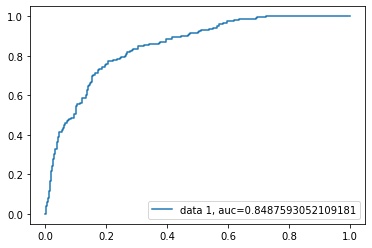

Max Accuracy 0.7813504823151125


In [151]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_curve, plot_roc_curve

fpr, tpr, _ = metrics.roc_curve(test_targets["target"],  predictions)
auc = metrics.roc_auc_score(test_targets["target"], predictions)
plt.plot(fpr,tpr,label=f"data 1, auc={auc}")
plt.legend(loc=4)
plt.show()


fpr, tpr, thresholds = roc_curve(test_targets["target"],  predictions)
accuracy_scores = []
for thresh in thresholds:
    accuracy_scores.append(accuracy_score(test_targets["target"], 
                                         [1 if m > thresh else 0 for m in predictions]))

accuracies = np.array(accuracy_scores)
max_accuracy = accuracies.max() 
max_accuracy_threshold =  thresholds[accuracies.argmax()]
print("Max Accuracy", max_accuracy)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

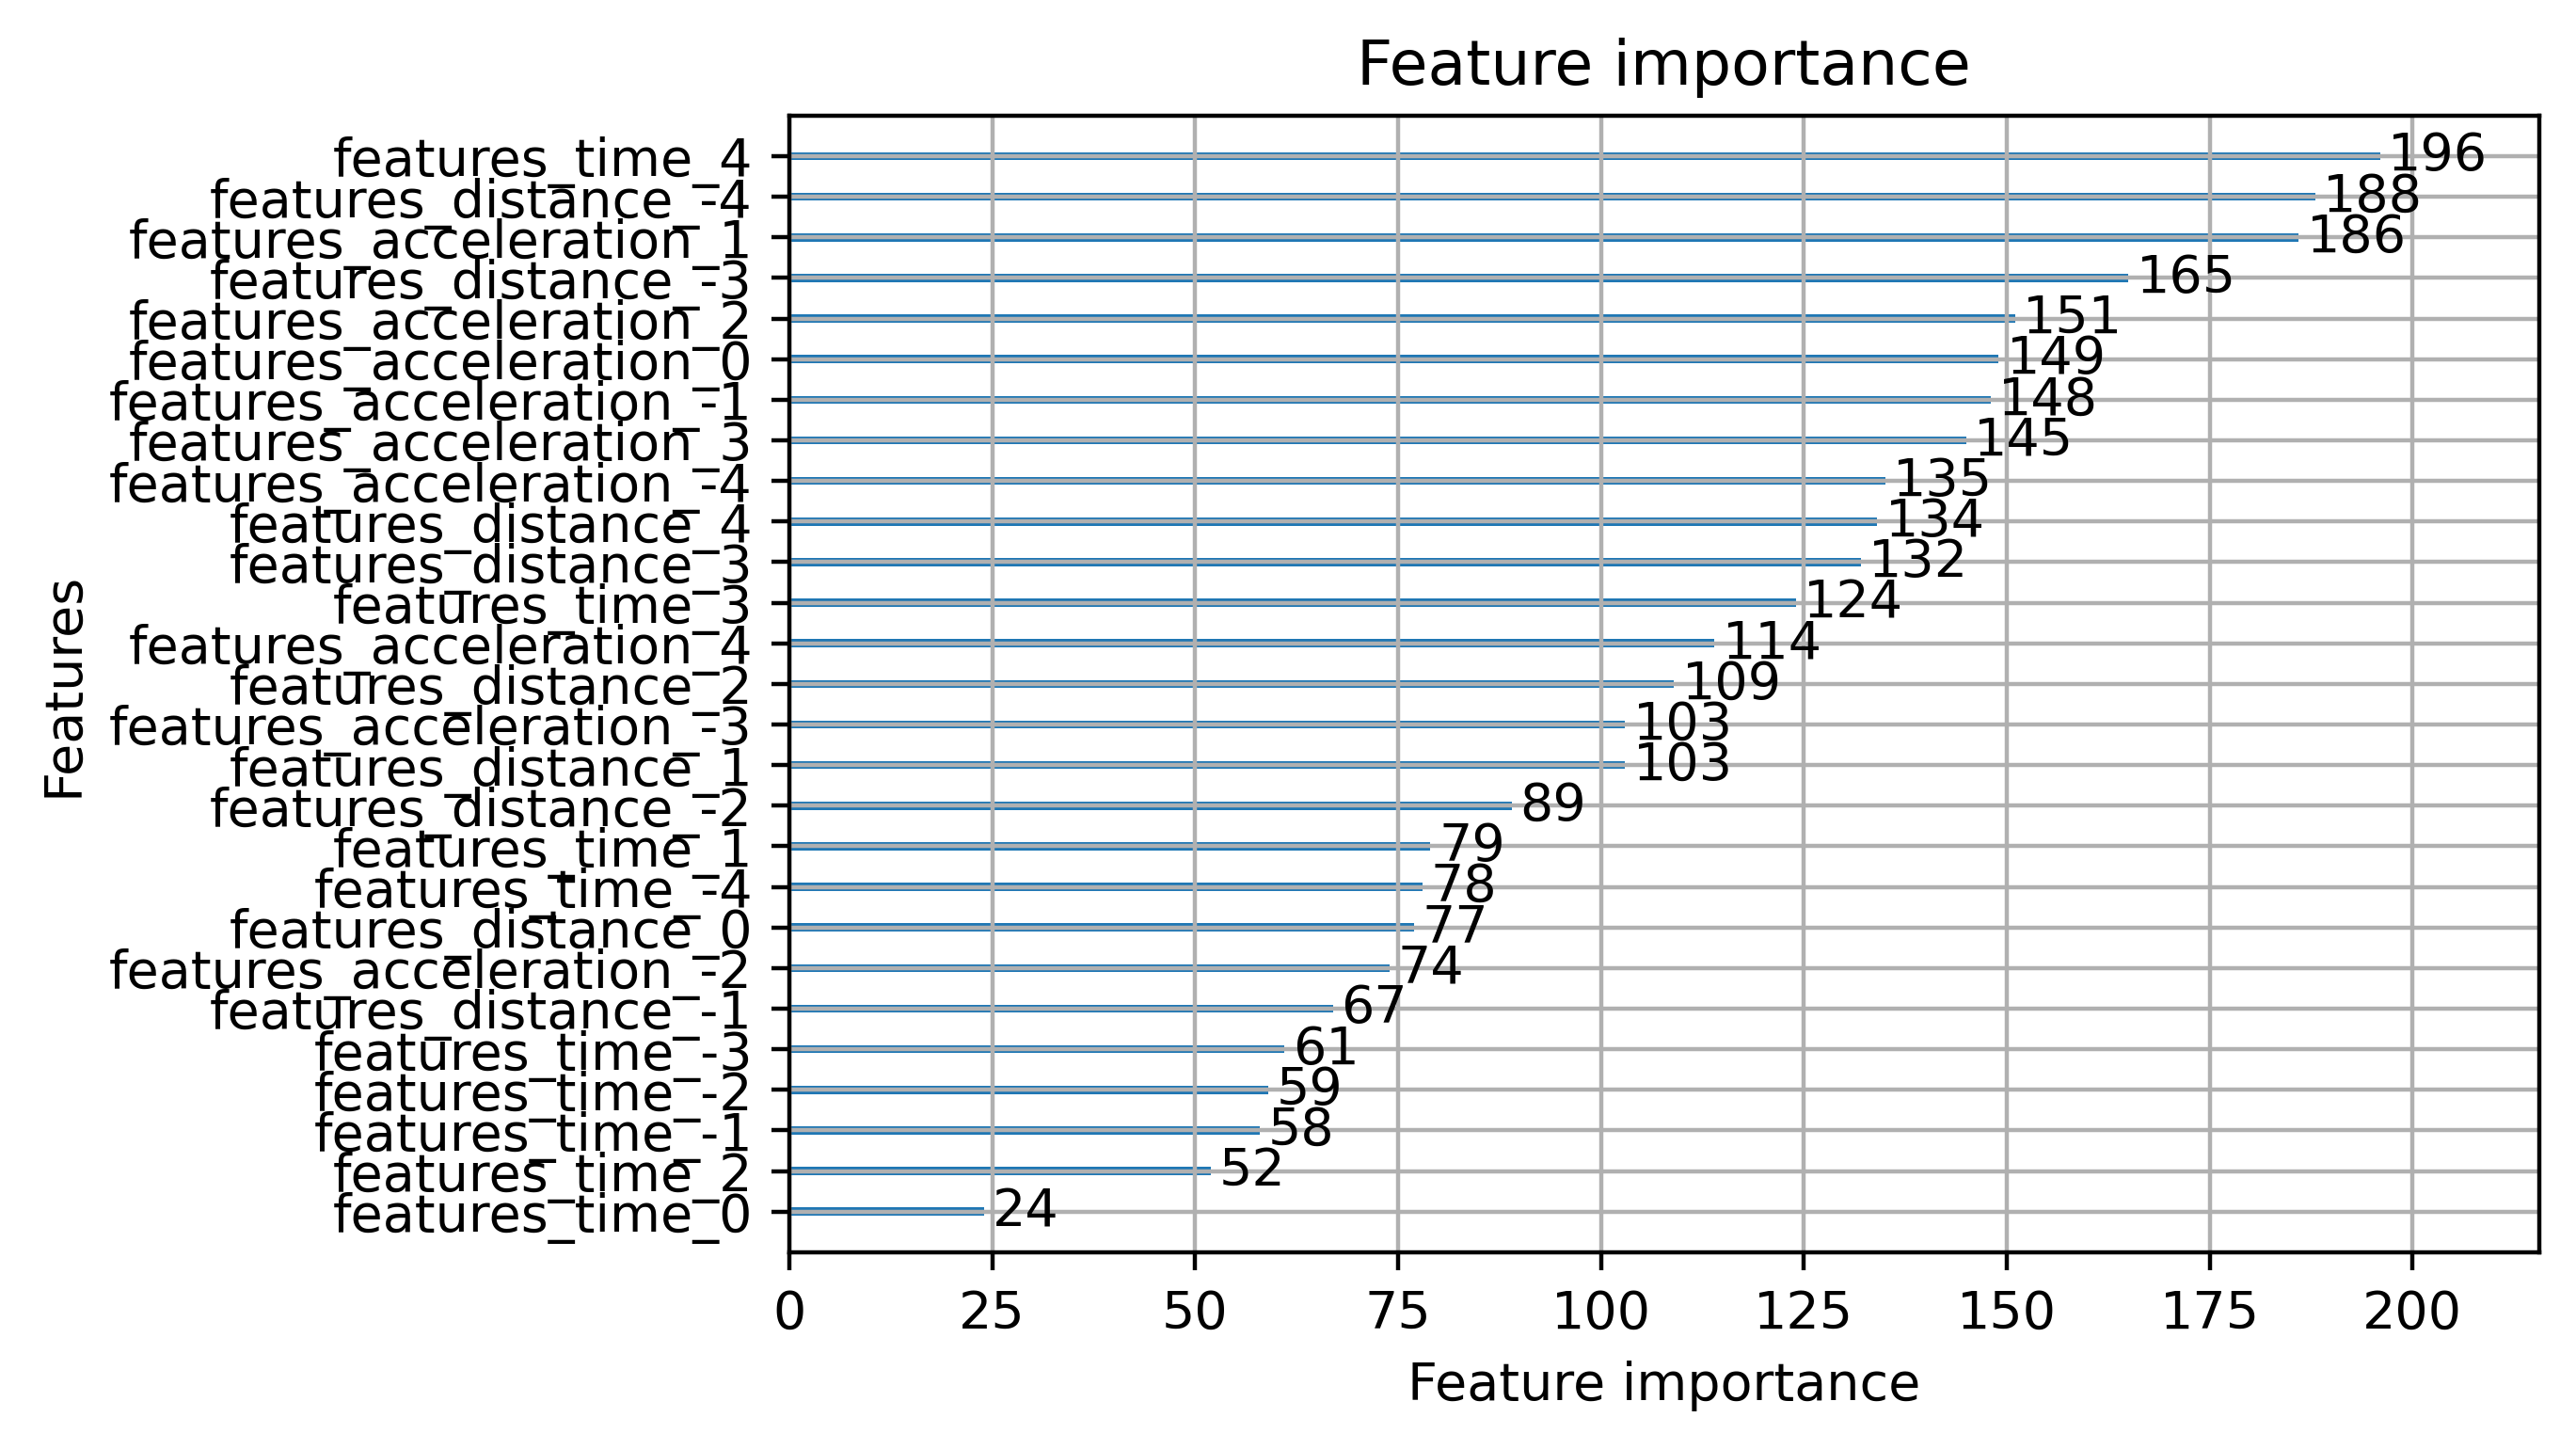

In [161]:

lgb.plot_importance(clf, dpi=400)

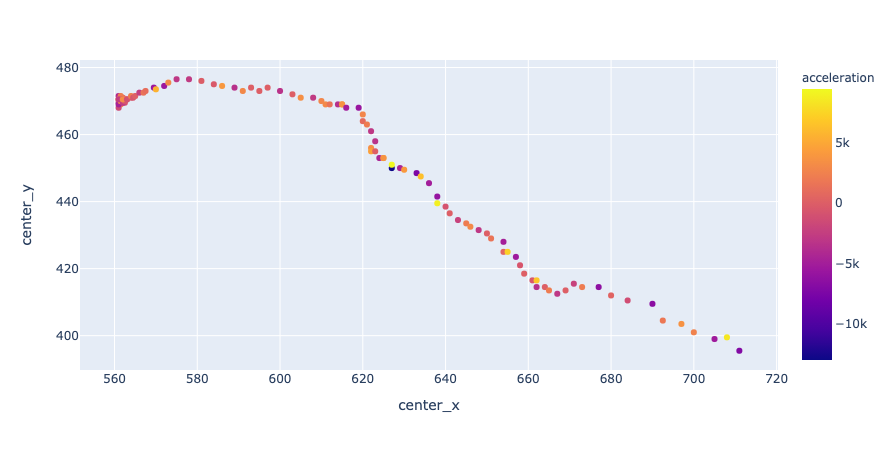

In [220]:
t = df.query("helmet_id == 'helmet_4'")
px.scatter(t, x="center_x", y="center_y", color="acceleration")

In [153]:
seconds_per_frame = 1/60
game = df.query("helmet_id == 'helmet_2'")
game = game.join(game[["center_x", "center_y"]].shift(1), lsuffix="_1", rsuffix="_0")
game["distance"] = np.sqrt(
    np.square(
        game["center_x_1"] - game["center_x_0"]) + 
    np.square(
        game["center_y_1"] - game["center_y_0"]
    )
)
game["distance"].iloc[0] = 0

game["velocity"] = game["distance"] / seconds_per_frame
game["time"] = game["frame"] / 60
game = game.join(game[["velocity"]].shift(1), lsuffix="_0", rsuffix="_1")
seconds_per_frame = 1 / 60
game["acceleration"] = (game["velocity_1"] - game["velocity_0"]) / seconds_per_frame
game["acceleration"].iloc[0] = 0

px.scatter(game, x="center_x_0", y="center_y_1", color="frame")

TypeError: '<' not supported between instances of 'str' and 'int'

In [153]:
from nfl.visualization.visualize import annotate_video_helmet_id

annotate_video_helmet_id(
    str(settings.path_original_train_videos / game.video.unique()[0]), 
    df,
    "test.mp4"
)
    